# Pipeline de Clasificación - Parte 3

Pipeline completo de clasificación de radiografías de tórax para detección de neumonía usando:
- Descriptores clásicos de forma y textura
- Clasificadores tradicionales (SVM, Random Forest, k-NN, Logistic Regression)
- CNN con BatchNormalization

**Métricas implementadas:** Accuracy, Precision, Recall, F1-Score, Matriz de Confusión, ROC/AUC

## 1. Dependencias

In [40]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import io, feature, filters
from skimage.feature import local_binary_pattern
import skimage.feature.texture as texture
import cv2

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

project_root = Path('..').resolve()
src_path = project_root / 'src'
sys.path.append(str(src_path))

# Alias para compatibilidad
try:
    from skimage.feature.texture import greycomatrix, greycoprops
except ImportError:
    # Si no existe, crear funciones wrapper compatibles
    greycomatrix = None
    greycoprops = None

print(f'Proyecto: {project_root}')

Proyecto: D:\SMVIA\Documentos\GitHub\TRABAJO-03


## 2. Configuración de rutas

In [41]:
DATA_ROOT = Path('../data/raw/chest_xray')
TRAIN_DIR = DATA_ROOT / 'train'
VAL_DIR = DATA_ROOT / 'val'
TEST_DIR = DATA_ROOT / 'test'

# Directorio de resultados
RESULTS_DIR = Path('../results')
FIGURES_DIR = RESULTS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)

print(f"Dataset: {DATA_ROOT} (existe: {DATA_ROOT.exists()})")
print(f"Resultados: {RESULTS_DIR}")

Dataset: ..\data\raw\chest_xray (existe: True)
Resultados: ..\results


## 3. Descriptores de Forma y Textura

In [42]:
def read_image_gray(path, size=IMG_SIZE):
    img = io.imread(path, as_gray=True)
    return cv2.resize((img * 255).astype('uint8'), size)

def descriptor_hog(img, pixels_per_cell=(16,16), cells_per_block=(2,2), orientations=9):
    fd, _ = feature.hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True)
    return fd

def descriptor_hu_moments(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
    moments = cv2.moments(thresh)
    hu = cv2.HuMoments(moments).flatten()
    return -np.sign(hu) * np.log10(np.abs(hu) + 1e-12)

def descriptor_contour_features(img):
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(cnts) == 0:
        return np.array([0, 0, 0])
    
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    circularity = 4 * np.pi * (area / (perimeter ** 2)) if perimeter > 0 else 0
    
    return np.array([area, perimeter, circularity])

def descriptor_lbp(img, P=8, R=1):
    lbp = local_binary_pattern(img, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype('float') / (hist.sum() + 1e-6)
    return hist

def descriptor_glcm_stats(img, distances=[1], angles=[0], levels=256):
    img_u = img.astype('uint8') if img.dtype != np.uint8 else img
    glcm = greycomatrix(img_u, distances=distances, angles=angles, levels=levels, 
                        symmetric=True, normed=True)
    feats = []
    for prop in ['contrast', 'correlation', 'energy', 'homogeneity']:
        feats.append(greycoprops(glcm, prop).ravel())
    return np.hstack(feats)

def descriptor_gabor_stats(img, frequencies=[0.1, 0.3], thetas=[0, np.pi/4, np.pi/2]):
    feats = []
    img_f = img.astype('float32') / 255.0
    for frequency in frequencies:
        for theta in thetas:
            kernel = cv2.getGaborKernel((21,21), 4.0, theta, 1.0/frequency, 0.5, 0, ktype=cv2.CV_32F)
            fimg = cv2.filter2D(img_f, cv2.CV_32F, kernel)
            feats.extend([fimg.mean(), fimg.std()])
    return np.array(feats)

def stats_first_order(img):
    arr = img.ravel().astype('float32')
    return np.array([arr.mean(), arr.std(), np.mean(np.abs(arr - arr.mean())),
                     np.percentile(arr, 25), np.percentile(arr, 50), np.percentile(arr, 75)])

## 4. Cargar imágenes

In [43]:
def gather_image_paths(data_dir):
    paths, labels = [], []
    for c in ['NORMAL', 'PNEUMONIA']:
        pattern = os.path.join(data_dir, c, '*.jpeg')
        files = glob(pattern) + glob(os.path.join(data_dir, c, '*.jpg')) + \
                glob(os.path.join(data_dir, c, '*.png'))
        paths.extend(files)
        labels.extend([0 if c=='NORMAL' else 1] * len(files))
    return paths, np.array(labels)

## 5. Extracción de características

In [44]:
def build_features(paths, include_shape=True, include_texture=True):
    feats_shape, feats_text = [], []
    
    for p in tqdm(paths):
        img = read_image_gray(p)
        
        if include_shape:
            try:
                sh_hu = descriptor_hu_moments(img)
                sh_hog = descriptor_hog(img)
                sh_contour = descriptor_contour_features(img)
                sh = np.hstack([sh_hu, sh_hog, sh_contour])
            except:
                sh = np.zeros(46)
        else:
            sh = np.array([])
        feats_shape.append(sh)
        
        if include_texture:
            try:
                tx_lbp = descriptor_lbp(img)
                tx_glcm = descriptor_glcm_stats(img)
                tx_gabor = descriptor_gabor_stats(img)
                tx_first = stats_first_order(img)
                tx = np.hstack([tx_lbp, tx_glcm, tx_gabor, tx_first])
            except:
                tx = np.zeros(26)
        else:
            tx = np.array([])
        feats_text.append(tx)
    
    X_shape = np.vstack([f if f.size>0 else np.zeros(1) for f in feats_shape])
    X_text = np.vstack([f if f.size>0 else np.zeros(1) for f in feats_text])
    return X_shape, X_text

## 6. Normalización

In [45]:
def normalize_features(X_train, X_test, method='standard'):
    scaler = StandardScaler() if method=='standard' else MinMaxScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_test), scaler

## 7. Clasificadores y Evaluación

In [46]:
def evaluate_classifiers(X, y, cv_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    models = {
        'SVM_rbf': SVC(kernel='rbf', probability=True, random_state=random_state),
        'SVM_linear': SVC(kernel='linear', probability=True, random_state=random_state),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=random_state),
        'kNN': KNeighborsClassifier(n_neighbors=5),
        'LogReg': LogisticRegression(max_iter=1000)
    }
    
    results = {}
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    for name, model in models.items():
        scores = cross_validate(model, X, y, cv=skf, scoring=scoring, return_train_score=False)
        results[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}
    return results, models

### ImageDataGenerator

In [47]:
def create_data_generators(train_dir=None, val_dir=None, img_size=(224, 224), batch_size=16):
    if train_dir is None:
        train_dir = TRAIN_DIR
    if val_dir is None:
        val_dir = VAL_DIR
    
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale'
    )
    
    val_gen = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=False
    )
    
    return train_gen, val_gen

## 8. Red Neuronal Convolucional

In [48]:
def simple_cnn(input_shape=(128, 128, 1), num_classes=2):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def get_cnn_callbacks(patience=5, min_lr=1e-7):
    return [
        EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=min_lr)
    ]

## 9. Workflow completo

### Visualizaciones

In [49]:
def plot_confusion_matrices(models_dict, X_test, y_test, figsize=(15, 10)):
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models_dict.items()):
        if idx >= len(axes):
            break
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=['NORMAL', 'PNEUMONIA'])
        disp.plot(ax=axes[idx], cmap='viridis', colorbar=True)
        axes[idx].set_title(f'{name}')
        axes[idx].grid(False)
    
    for idx in range(len(models_dict), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    return fig

def plot_roc_curves(models_dict, X_test, y_test, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    
    for name, model in models_dict.items():
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") \
                  else model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{name} (AUC={roc_auc:.3f})')
        ax.fill_between(fpr, tpr, alpha=0.1)
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Aleatorio')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title('Curvas ROC')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    return fig

In [50]:
def save_results_table(results_dict, path=None):
    if path is None:
        path = RESULTS_DIR / 'comparison_summary.csv'
    df = pd.DataFrame(results_dict).T
    df.to_csv(path)
    print(f'Resultados guardados en: {path}')
    print('\nResumen:')
    print(df.round(4))
    return df

def plot_metrics_comparison(results_dict, figsize=(12, 6)):
    df = pd.DataFrame(results_dict).T
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    df.plot(kind='bar', ax=axes[0], rot=45)
    axes[0].set_title('Comparación de Métricas')
    axes[0].set_ylabel('Score')
    axes[0].set_xlabel('Modelo')
    axes[0].legend(title='Métrica')
    axes[0].grid(alpha=0.3, axis='y')
    axes[0].set_ylim([0, 1])
    
    f1_scores = df['f1'].sort_values(ascending=True)
    f1_scores.plot(kind='barh', ax=axes[1], color='steelblue')
    axes[1].set_title('F1-Score')
    axes[1].set_xlabel('F1-Score')
    axes[1].set_ylabel('Modelo')
    axes[1].grid(alpha=0.3, axis='x')
    axes[1].set_xlim([0, 1])
    
    plt.tight_layout()
    return fig

## 10. Ejecución del Pipeline Completo

In [51]:
# PASO 1: Cargar rutas de imágenes

train_paths, train_labels = gather_image_paths(TRAIN_DIR)
test_paths, test_labels = gather_image_paths(TEST_DIR)

# Mezclar para evitar que todas sean de una clase
indices_train = np.random.RandomState(42).permutation(len(train_paths))
train_paths = [train_paths[i] for i in indices_train]
train_labels = train_labels[indices_train]

indices_test = np.random.RandomState(42).permutation(len(test_paths))
test_paths = [test_paths[i] for i in indices_test]
test_labels = test_labels[indices_test]

print(f"\nTrain: {len(train_paths)} imágenes")
print(f"  - NORMAL: {sum(train_labels == 0)}")
print(f"  - PNEUMONIA: {sum(train_labels == 1)}")
print(f"\nTest: {len(test_paths)} imágenes")
print(f"  - NORMAL: {sum(test_labels == 0)}")
print(f"  - PNEUMONIA: {sum(test_labels == 1)}")


Train: 5216 imágenes
  - NORMAL: 1341
  - PNEUMONIA: 3875

Test: 624 imágenes
  - NORMAL: 234
  - PNEUMONIA: 390


In [52]:
# PASO 2: Extraer características (usar subset para prueba rápida)
n_train = 500  # Cambiar a len(train_paths) para usar todo el dataset
n_test = 200   # Cambiar a len(test_paths) para usar todo el dataset

train_subset_paths = train_paths[:n_train]
train_subset_labels = train_labels[:n_train]
test_subset_paths = test_paths[:n_test]
test_subset_labels = test_labels[:n_test]

print(f"\nDistribución de clases en train subset:")
print(f"  - NORMAL: {sum(train_subset_labels == 0)}")
print(f"  - PNEUMONIA: {sum(train_subset_labels == 1)}")

print(f"\nExtrayendo características de {n_train} imágenes de entrenamiento...")
X_train_shape, X_train_text = build_features(train_subset_paths, include_shape=True, include_texture=True)

print(f"\nExtrayendo características de {n_test} imágenes de prueba...")
X_test_shape, X_test_text = build_features(test_subset_paths, include_shape=True, include_texture=True)

# Combinar descriptores
X_train = np.hstack([X_train_shape, X_train_text])
X_test = np.hstack([X_test_shape, X_test_text])

print(f"\nForma de características de entrenamiento: {X_train.shape}")
print(f"Forma de características de prueba: {X_test.shape}")


Distribución de clases en train subset:
  - NORMAL: 141
  - PNEUMONIA: 359

Extrayendo características de 500 imágenes de entrenamiento...


100%|██████████| 500/500 [00:29<00:00, 16.96it/s]



Extrayendo características de 200 imágenes de prueba...


100%|██████████| 200/200 [00:11<00:00, 17.24it/s]


Forma de características de entrenamiento: (500, 6120)
Forma de características de prueba: (200, 6120)


In [53]:
# PASO 3: Normalizar características
X_train_norm, X_test_norm, scaler = normalize_features(X_train, X_test, method='standard')
print(f"\nCaracterísticas normalizadas con StandardScaler")
print(f"Media train (después): {X_train_norm.mean():.6f}")
print(f"Std train (después): {X_train_norm.std():.6f}")


Características normalizadas con StandardScaler
Media train (después): -0.000000
Std train (después): 0.997874


In [54]:
# PASO 4: Entrenar y evaluar clasificadores con validación cruzada
results_cv, models_dict = evaluate_classifiers(X_train_norm, train_subset_labels, cv_splits=3)
print("\nResultados de validación cruzada (3-fold):")
print("-" * 60)
results_df = pd.DataFrame(results_cv).T
print(results_df.round(4))


Resultados de validación cruzada (3-fold):
------------------------------------------------------------
              accuracy  precision  recall      f1
SVM_rbf          0.958     0.9546  0.9888  0.9713
SVM_linear       0.956     0.9695  0.9694  0.9694
RandomForest     0.938     0.9414  0.9749  0.9577
kNN              0.922     0.9794  0.9109  0.9436
LogReg           0.954     0.9695  0.9666  0.9680


In [55]:
# PASO 5: Entrenar modelos en el conjunto completo y evaluar en test

trained_models = {}
for name, model in models_dict.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train_norm, train_subset_labels)
    trained_models[name] = model
    
    # Predicción en test
    y_pred = model.predict(X_test_norm)
    acc = accuracy_score(test_subset_labels, y_pred)
    prec = precision_score(test_subset_labels, y_pred)
    rec = recall_score(test_subset_labels, y_pred)
    f1 = f1_score(test_subset_labels, y_pred)
    
    print(f"  Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")


Entrenando SVM_rbf...
  Accuracy: 0.7000 | Precision: 0.6705 | Recall: 0.9833 | F1: 0.7973

Entrenando SVM_linear...
  Accuracy: 0.7000 | Precision: 0.6705 | Recall: 0.9833 | F1: 0.7973

Entrenando SVM_linear...
  Accuracy: 0.7450 | Precision: 0.7066 | Recall: 0.9833 | F1: 0.8223

Entrenando RandomForest...
  Accuracy: 0.7450 | Precision: 0.7066 | Recall: 0.9833 | F1: 0.8223

Entrenando RandomForest...
  Accuracy: 0.7300 | Precision: 0.6919 | Recall: 0.9917 | F1: 0.8151

Entrenando kNN...
  Accuracy: 0.8100 | Precision: 0.7929 | Recall: 0.9250 | F1: 0.8538

Entrenando LogReg...
  Accuracy: 0.7600 | Precision: 0.7195 | Recall: 0.9833 | F1: 0.8310
  Accuracy: 0.7300 | Precision: 0.6919 | Recall: 0.9917 | F1: 0.8151

Entrenando kNN...
  Accuracy: 0.8100 | Precision: 0.7929 | Recall: 0.9250 | F1: 0.8538

Entrenando LogReg...
  Accuracy: 0.7600 | Precision: 0.7195 | Recall: 0.9833 | F1: 0.8310



GMatrices de confusión...


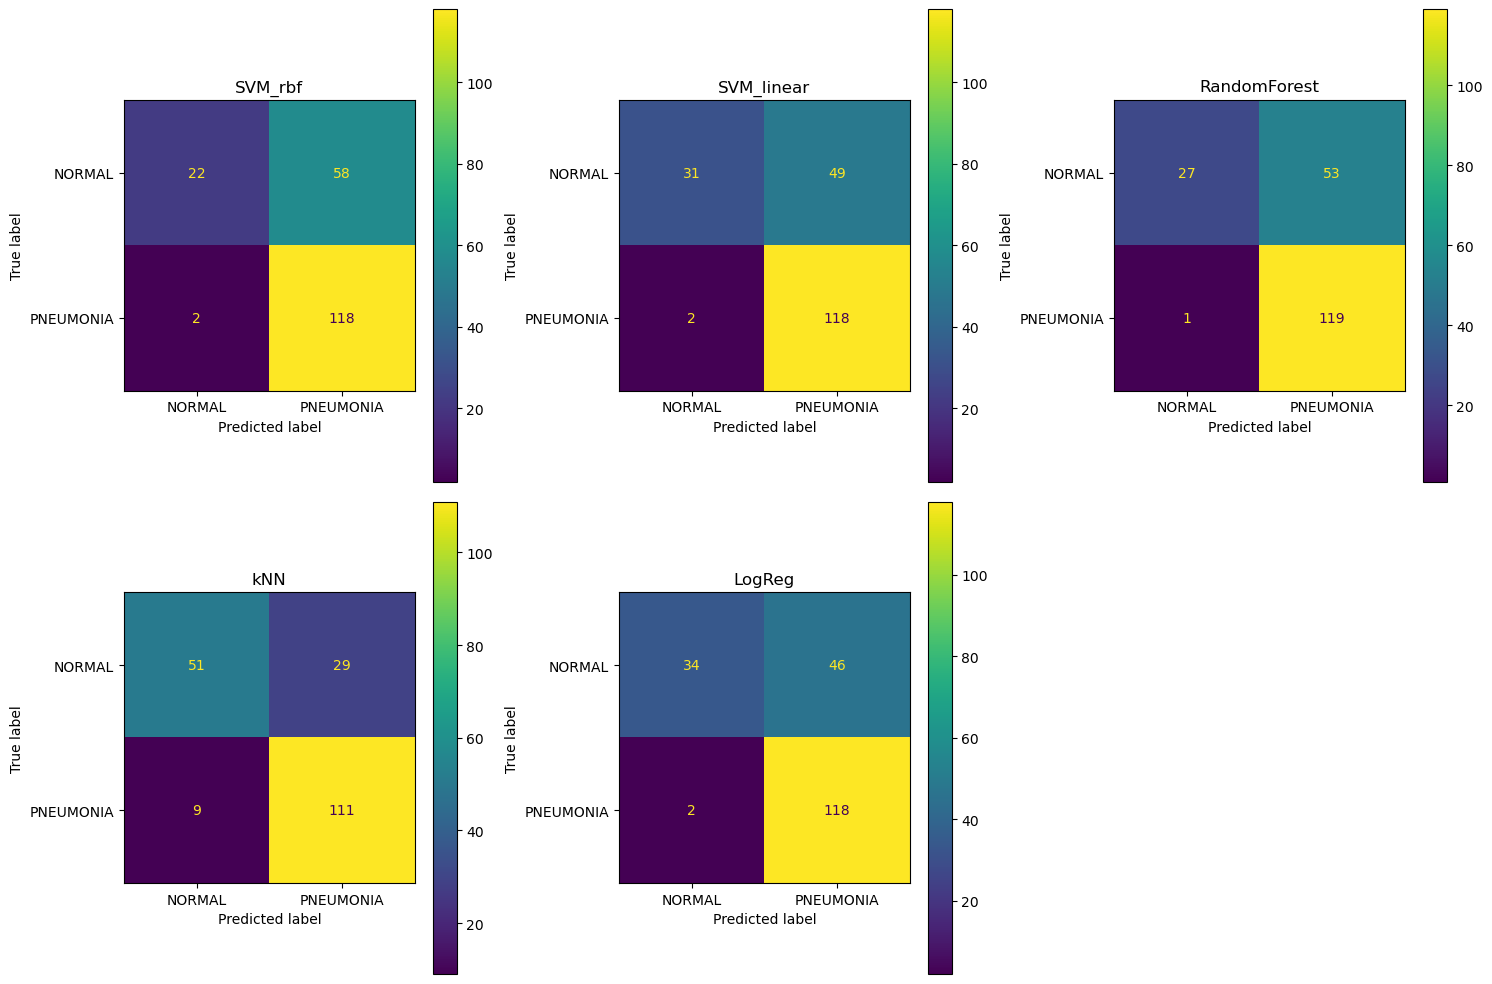


Generando curvas ROC...


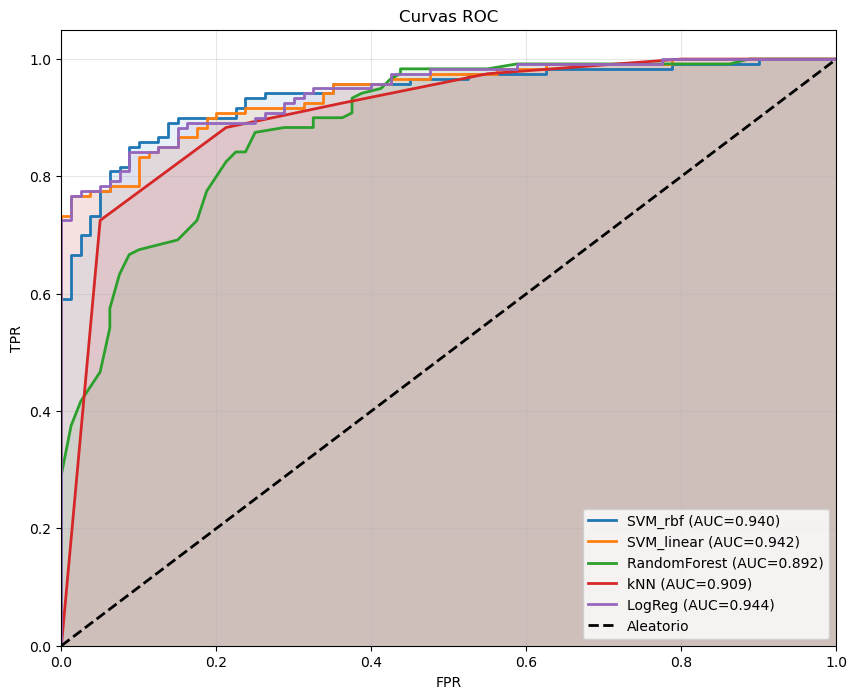


Generando gráfico de comparación de métricas...


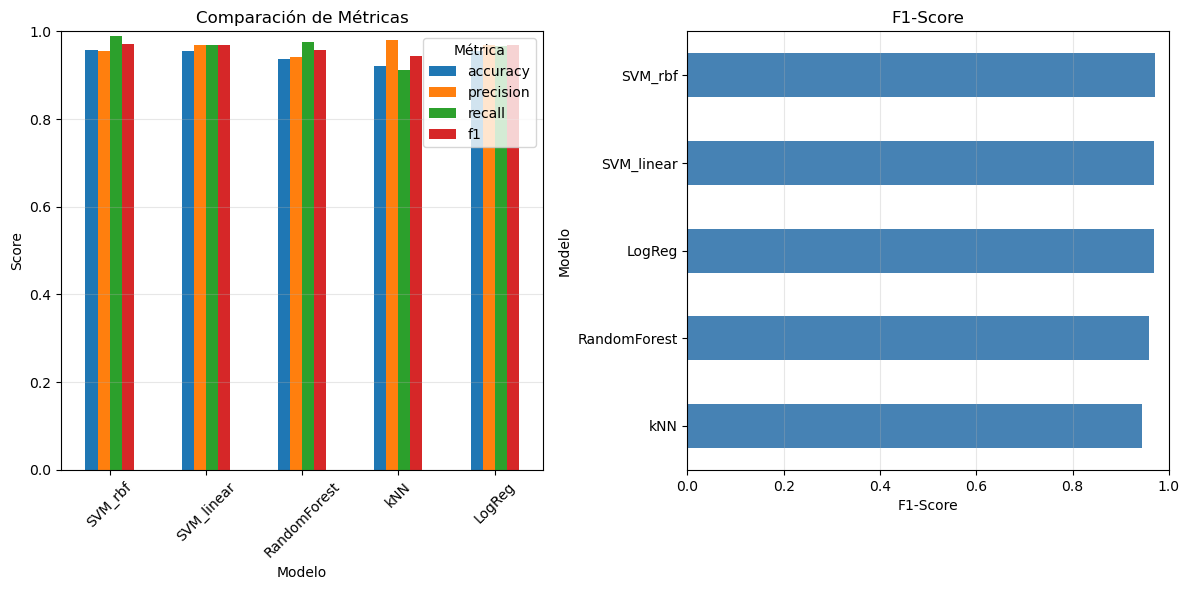


Figuras guardadas en: ..\results\figures


In [56]:
# Matrices de confusión
print("\nGMatrices de confusión...")
fig_cm = plot_confusion_matrices(trained_models, X_test_norm, test_subset_labels)
plt.savefig(FIGURES_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Curvas ROC
print("\nGenerando curvas ROC...")
fig_roc = plot_roc_curves(trained_models, X_test_norm, test_subset_labels)
plt.savefig(FIGURES_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparación de métricas
print("\nGenerando gráfico de comparación de métricas...")
fig_metrics = plot_metrics_comparison(results_cv)
plt.savefig(FIGURES_DIR / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFiguras guardadas en: {FIGURES_DIR}")

In [58]:
# PASO 7: Guardar tabla de resultados

results_df = save_results_table(results_cv)
print(f"Figuras guardadas en: {FIGURES_DIR}")

Resultados guardados en: ..\results\comparison_summary.csv

Resumen:
              accuracy  precision  recall      f1
SVM_rbf          0.958     0.9546  0.9888  0.9713
SVM_linear       0.956     0.9695  0.9694  0.9694
RandomForest     0.938     0.9414  0.9749  0.9577
kNN              0.922     0.9794  0.9109  0.9436
LogReg           0.954     0.9695  0.9666  0.9680
Figuras guardadas en: ..\results\figures
